In [1]:
import os
import numpy as np
import collections
import pickle
import argparse
import tensorflow as tf
import time
import matplotlib.pyplot as plt
%matplotlib inline

/software/Anaconda3-5.0.1-el7-x86_64/envs/DL_GPU_cuda_9.0/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


# 3. RNN for predicting characters

The following online post is a very good presentation of RNN’s and LSTM’s<br>
http://colah.github.io/posts/2015-08-Understanding-LSTMs/

In this code there is a generic network that takes as input a ‘cell’ (an RNN, an LSTM etc.) There is a generic training function, a generic testing function that produces a test loss, and a generic simulation function. Each of these functions gets input a ‘cell’ that is defined in some function.

## START LSTM SAMPLE CODE

#### Parameters used in code

In [2]:
parser = argparse.ArgumentParser()
parser.add_argument('--data_dir', default='./')
parser.add_argument('--save_dir', default='./')
# Dimension of hidden layer variables h and c
parser.add_argument('--num_units', default=128*2)
parser.add_argument('--batch_size', default=64)
# Number of steps in each batch for training
parser.add_argument('--num_steps', default=75)
parser.add_argument('--num_epochs', default=3)
# Time step
parser.add_argument('--lr', default=0.002)
# Number of possible inputs/outputs 
parser.add_argument('--num_chars')
parser.add_argument('--num_batches',default=20)
args, unparsed = parser.parse_known_args()

In [3]:
def timer(start, end):
    hrs, rem = divmod(end-start, 3600)
    mins, secs = divmod(rem, 60)
    print('{:0>2} hours {:0>2} minutes {:05.2f} seconds'.format(int(hrs), int(mins), secs))

#### Class for handling the text data, creating vocabulary (in this case just the 65 characters). Creating batches and loading batches

In [4]:
class TextLoader():

    def __init__(self, data_dir, batch_size=64, seq_length=50, encoding='utf-8'):
        self.data_dir = data_dir
        self.encoding = encoding
        self.batch_size = batch_size
        self.seq_length = seq_length

        self.input_file = os.path.join(data_dir, '/project2/cmsc25025/Shakespear/tinyshakespeare.txt')
        self.vocab_file = os.path.join(data_dir, '/project2/cmsc25025/Shakespear/vocab.pkl')
        # Numeric file of characters translated to indices.
        self.tensor_file = os.path.join(data_dir, '/project2/cmsc25025/Shakespear/data.npy')
        
        if not (os.path.exists(self.vocab_file) and os.path.exists(self.tensor_file)):
            print('it seems we havent processed the text data yet: reading the shakespear')
            self.preprocess(self.input_file, self.vocab_file, self.tensor_file)
        else:
            print('there are preprocessed data - lets load it')
            self.load_preprocessed(self.vocab_file, self.tensor_file)

        self.create_batches()
        self.reset_batch_pointer()

    # Create numeric file.
    def preprocess(self, input_file=None, vocab_file=None, tensor_file=None, saveit=True):
        if input_file is not None:
            self.input_file = input_file
        if vocab_file is not None:
            self.vocab_file = vocab_file
        if tensor_file is not None:
            self.tensor_file = tensor_file

        with open(self.input_file, 'r') as f:
            data = f.read()
        #data = data.lower()
        self.total_length = len(data)
        counter = collections.Counter(data)
        count_pairs = sorted(counter.items(), key=lambda x: -x[1])
        self.chars, _ = zip(*count_pairs)
        self.vocab_size = len(self.chars)
        self.vocab_to_idx = dict(zip(self.chars, range(len(self.chars))))
        self.idx_to_vocab = dict(zip(self.vocab_to_idx.values(), self.vocab_to_idx.keys()))

        if saveit:
            with open(self.vocab_file, 'wb') as f:  # saving dictionary so we don't compute it again
                pickle.dump(self.chars, f)
            self.tensor = np.array(list(map(self.vocab_to_idx.get, data)))
            np.save(self.tensor_file, self.tensor)  # saving the numerified data
    # Load numeric file create dictionaries for char2idx and back
    def load_preprocessed(self, vocab_file=None, tensor_file=None):
        if vocab_file is not None:
            self.vocab_file = vocab_file
        if tensor_file is not None:
            self.tensor_file = tensor_file

        with open(self.vocab_file, 'rb') as f:
            self.chars = pickle.load(f)

        # attributes
        self.vocab_size = len(self.chars)
        self.vocab = dict(zip(self.chars, range(self.vocab_size)))
        self.vocab_to_idx = dict(zip(self.chars, range(len(self.chars))))
        self.idx_to_vocab = dict(zip(self.vocab_to_idx.values(), self.vocab_to_idx.keys()))
        self.tensor = np.load(tensor_file)
        self.num_batches = int(self.tensor.size / (self.batch_size * self.seq_length))
            
    # tensor size = the length of the entire data sequence
    # divide into batch_size sub sequences and stack
    # cut those by seq_length to produce batches of [batch size, seq_length] sized examples
    def create_batches(self):

        
        self.num_batches = int(self.tensor.size / (self.batch_size * self.seq_length))

        if self.num_batches == 0:
            assert False, 'Not enough data. Make seq_length and/or batch_size smaller'

        self.tensor = self.tensor[:self.num_batches * self.batch_size * self.seq_length]  # so we get an even divide
        xdata = self.tensor
        ydata = np.copy(self.tensor)

        # ydata is one step ahead of x and last item is first item of x 
        # to get sequences of same length    
        ydata[:-1] = xdata[1:] 
        ydata[-1] = xdata[0]

        self.x_batches = np.split(xdata.reshape(self.batch_size, -1), self.num_batches, 1)
        self.y_batches = np.split(ydata.reshape(self.batch_size, -1), self.num_batches, 1)
        
        self.train_num_batches=np.int32(self.num_batches*.8)
        self.test_num_batches=self.num_batches-self.train_num_batches
        self.train_x_batches=self.x_batches[0:self.train_num_batches]
        self.train_y_batches=self.y_batches[0:self.train_num_batches]
        self.test_x_batches=self.x_batches[self.train_num_batches:]
        self.test_y_batches=self.y_batches[self.train_num_batches:]

        # xdata: L length
        # xdata reshaped: batch_size, (L/batch_size) length following natural indexing
        # np.split: into num batches batches along the width(sentence)

    def next_batch_train(self):
        x, y = self.train_x_batches[self.pointer], self.train_y_batches[self.pointer]
        self.pointer += 1
        return x,y
    
    def next_batch_test(self):
        x, y = self.test_x_batches[self.pointer], self.test_y_batches[self.pointer]
        self.pointer += 1
        return x,y

    def reset_batch_pointer(self):
        self.pointer = 0

In [5]:
loader = TextLoader(args.data_dir, batch_size=args.batch_size, seq_length=args.num_steps)
args.num_chars = loader.vocab_size
print('num chars',args.num_chars)
print('num batches',loader.num_batches)

there are preprocessed data - lets load it
num chars 65
num batches 232


#### Basic RNN

In [6]:
class MyBasicRNNCell(tf.contrib.rnn.BasicRNNCell):

    def build(self, inputs_shape):

        input_depth = inputs_shape[1].value
        
        self.W = self.add_variable(name="W", shape=[input_depth + self._num_units, self._num_units])
        self.b = self.add_variable(name="b", shape=[self._num_units], initializer=tf.zeros_initializer())
        
        self.built = True

    def call(self, inputs, state):
        """Most basic RNN: output = new_state = act(W * input + U * state + B)."""
        
        output = tf.tanh(tf.matmul(tf.concat([inputs, state], 1), self.W)) + self.b

        return output, output

#### Basic LSTM

In [7]:
LSTMStateTuple = collections.namedtuple("LSTMStateTuple", ("c", "h"))

class MyBasicLSTMCell(tf.contrib.rnn.BasicLSTMCell):

    def build(self, inputs_shape):

        input_depth = inputs_shape[1].value
        #The four W weights for the four different input computations concatenated
        self.W = self.add_variable(name="W", shape=[input_depth + self._num_units, 4 * self._num_units])
        self.b= self.add_variable(name="b", shape=[4 * self._num_units], initializer=tf.zeros_initializer())

        self.built = True

    def call(self, inputs, state):

        one = tf.constant(1, dtype=tf.int32)
        c, h = state

        gate_inputs = tf.matmul(tf.concat([inputs, h], axis=1), self.W) + self.b

        input_gate_weights, input_weights, forget_gate_weights, output_gate_weights = tf.split(
            value=gate_inputs, num_or_size_splits=4, axis=one)

        # forget gating
        forget_bias_tensor = tf.constant(1.0, dtype=forget_gate_weights.dtype)
        forget_gate = tf.sigmoid(forget_gate_weights + forget_bias_tensor)
        gated_memory = c * forget_gate

        # input gating
        processed_new_input = tf.tanh(input_weights)
        input_gate = tf.sigmoid(input_gate_weights)
        gated_input = input_gate * processed_new_input

        # updating memory
        new_c = gated_memory + gated_input

        # output gating
        processed_memory = tf.tanh(new_c)
        output_gate = tf.sigmoid(output_gate_weights)
        new_h = processed_memory * output_gate

        new_state = tf.nn.rnn_cell.LSTMStateTuple(new_c, new_h)

        return new_h, new_state

#### Function incorporating chosen Cell type (LSTM, RNN). Unrolling it and adding the loss computation.

In [8]:
def network(myCell,inputs,targets):

    with tf.variable_scope('embedding_matrix'):
        # Embedding matrix of dimension num_units (here same as dim of hidden units) is trained
        embedding = tf.get_variable('embedding', [args.num_chars, args.num_units])
        embedded_inputs = tf.nn.embedding_lookup(embedding, inputs)
        inputs_list = tf.unstack(embedded_inputs, axis=1)  # shape: a list of [batch_size, num_units] length num_steps

    with tf.variable_scope('Cell') as myscope:
        # Setup the `F' function either a simple RNN unit or an LSTM
        cell = myCell(args.num_units)
        init_state = cell.zero_state(args.batch_size, tf.float32)
        state = init_state
        outputs = []

        for time_, input in enumerate(inputs_list):
            # Unroll the RNN into as many layers as there are observations in each
            # training sequence. The weights are all tied with the reuse command.
            if time_ > 0:
                myscope.reuse_variables()
           
            output, state = cell(input, state)
            # Append all the outputs - hidden variables
            outputs.append(output)
    # All hidden outputs for each batch and every step in the batch are reshaped
    # as one long matrix to be transformed to logits by Vand compared to targets.
        output_reshaped = tf.reshape(tf.concat(outputs, 1), [-1, args.num_units])

        final_state = state

    # Create a softmax from the output of each step in each of the samples in the batch.
    with tf.variable_scope('regression'):
        V = tf.get_variable('V', [args.num_units, args.num_chars])
        c = tf.get_variable('c', [args.num_chars], initializer=tf.constant_initializer(0.0))
        logits = tf.matmul(output_reshaped, V) + c
        prob = tf.nn.softmax(logits)

    # Evaluate with respect to ground truth using log-likeihood
    with tf.variable_scope('cost'):
        targets_straightened = tf.reshape(targets, [-1])
        crossentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits, 
                                                    labels=targets_straightened)
        loss = tf.reduce_mean(crossentropy)
        cost = loss/args.batch_size/args.num_steps

    with tf.variable_scope('optimizer'):
        train_step = tf.train.AdamOptimizer(args.lr).minimize(loss)

    with tf.variable_scope('saver'):
        saver = tf.train.Saver()
    return init_state, train_step, loss, final_state, saver, prob

#### Run the training

In [9]:
def trainer(myCell,num_batches=None):
    
    start_time = time.time()
    tf.reset_default_graph()
    # Define the placeholders
    with tf.variable_scope('placeholders'):
            inputs = tf.placeholder(tf.int32, [args.batch_size, args.num_steps])
            targets = tf.placeholder(tf.int32, [args.batch_size, args.num_steps])
    # Create the network
    init_state, train_step, loss, final_state, saver, prob=network(myCell,inputs,targets)
    print('train_num_batches',loader.train_num_batches)
    
    if (num_batches is None):
        num_batches=loader.train_num_batches

    with tf.Session() as sess:
         
        sess.run(tf.global_variables_initializer())
        # computation graph for training
        training_losses = []
        training_errors = []

        for epoch in range(args.num_epochs):
            loader.reset_batch_pointer()
            # Initial state - 0
            state_ = sess.run(init_state)
            training_loss = 0
            probs = []
            for batch in range(num_batches):

                x, y = loader.next_batch_train()

                feed_dict = dict()
                feed_dict[inputs] = x
                feed_dict[targets] = y
                
                # RNN has just an input state.
                if ('RNN' in myCell.__name__):
                    feed_dict[init_state] = state_
                else:
                    # LSTM has a 'c' and an 'h' component of the hidden state.
                    feed_dict[init_state.c] = state_.c
                    feed_dict[init_state.h] = state_.h
                # Output states of current batch get fed into initial state of next batch.
                train_loss_, state_, _ = sess.run([loss, final_state, train_step], feed_dict=feed_dict)
                training_loss += train_loss_
            probs = sess.run([prob], feed_dict=feed_dict)
            yhat = [max(enumerate(p), key = lambda x : x[1])[0] for p in probs[0]]
            yreal =  [y2 for y1 in y for y2 in y1]
            training_error = np.mean([yreal[i]!=yhat[i] for i in range(len(yhat))])
            training_errors.append(training_error)
            training_loss=training_loss/num_batches
            print('epoch:', epoch, 'loss:',  training_loss, 'error:',  training_error)
            training_losses.append(training_loss)
        saver.save(sess, os.path.join(args.save_dir, 'saved_model'))
    
    end_time = time.time()
    
    timer(start_time, end_time)
    return(training_losses, training_errors)

#### Reload model and run a simulated prediction

In [10]:
def Synthesize(MyCell,init_string="None"):
    tf.reset_default_graph()
    num_steps_bak=args.num_steps
    batch_size_bak=args.batch_size
    args.num_steps=1
    args.batch_size=1
    with tf.variable_scope('placeholders'):
            inputs = tf.placeholder(tf.int32, [args.batch_size, args.num_steps])
            targets = tf.placeholder(tf.int32, [args.batch_size, args.num_steps])
    init_state, train_step, loss, final_state, saver, prob=network(MyCell,inputs,targets)

    # Define initialization
    if (init_string is None):
        initialization = 'Where are you going today?'
    else:
        initialization = init_string
    loader= TextLoader(args.data_dir, batch_size=1, seq_length=1)

    forecast_data=np.array(list(map(loader.vocab_to_idx.get, initialization)))
    print(forecast_data)
    forecast_range = 100
    top_k=5
 
    with tf.Session() as sess:

        # Load saved model
        saver.restore(sess, 'saved_model')
        state_ = sess.run(init_state)

        # Run rnn on initialization data to get final hidden state before simulation
        state_ = sess.run(init_state)
        print('data length',forecast_data.shape[0])
        for i in range(forecast_data.shape[0]):

            feed_dict = dict()
            # Feed current predicted
            feed_dict[inputs] = forecast_data[i].reshape(args.batch_size, args.num_steps)
            if ('RNN' in MyCell.__name__):
                feed_dict[init_state] = state_
            else:
                feed_dict[init_state.c] = state_.c
                feed_dict[init_state.h] = state_.h
            # Get new hidden state and prediction probabilities
            predicted_prob, state_ = sess.run([prob, final_state], feed_dict=feed_dict)

        # last state of this step becomes first state of simulation

        for i in range(forecast_range):

            feed_dict = dict()
            # Feed current predicted
            feed_dict[inputs] = forecast_data[-args.num_steps:].reshape(args.batch_size, args.num_steps)
            if ('RNN' in MyCell.__name__):
                feed_dict[init_state] = state_
            else:
                feed_dict[init_state.c] = state_.c
                feed_dict[init_state.h] = state_.h
            predicted_prob, state_ = sess.run([prob, final_state], feed_dict=feed_dict)

            predicted_prob = predicted_prob.ravel()
            # Simulate from top top_k probs
            predicted_prob[np.argsort(predicted_prob)[:-top_k]] = 0
            predicted_prob = predicted_prob/np.sum(predicted_prob)
            sample = np.random.choice(args.num_chars, 1, p=predicted_prob)[0]


            forecast_data = np.hstack((forecast_data, sample))

    forecasted_chars = np.asarray([loader.idx_to_vocab[elem] for elem in forecast_data])

    print(''.join(forecasted_chars))
  
    args.num_steps=num_steps_bak
    args.batch_size=batch_size_bak

#### Get loss on test set

In [11]:
def Tester(MyCell, num_batches=None):
    tf.reset_default_graph()
    with tf.variable_scope('placeholders'):
            inputs = tf.placeholder(tf.int32, [args.batch_size, args.num_steps])
            targets = tf.placeholder(tf.int32, [args.batch_size, args.num_steps])
    init_state, train_step, loss, final_state, saver, prob=network(MyCell,inputs,targets)

    # Define initialization
    initialization = 'Where are you going today?'
    loader= TextLoader(args.data_dir, batch_size=args.batch_size, seq_length=args.num_steps)

    forecast_data=np.array(list(map(loader.vocab_to_idx.get, initialization)))
    print(forecast_data)
    forecast_range = 100
    top_k=5
 
    if (num_batches is None):
        num_batches=loader.test_num_batches
    with tf.Session() as sess:

        # Load saved model
        saver.restore(sess, 'saved_model')
        state_ = sess.run(init_state)

        loader.reset_batch_pointer()
        
         # Get test error loss
        test_loss = 0
        print('num_batches',num_batches)

        for batch in range(num_batches):

            x, y = loader.next_batch_test()

            feed_dict = dict()
            feed_dict[inputs] = x
            feed_dict[targets] = y

            if ('RNN' in MyCell.__name__):
                feed_dict[init_state] = state_
            else:
                feed_dict[init_state.c] = state_.c
                feed_dict[init_state.h] = state_.h

            test_loss_, state_= sess.run([loss, final_state], feed_dict=feed_dict)
            test_loss += test_loss_
        probs = sess.run([prob], feed_dict=feed_dict)
        yhat = [max(enumerate(p), key = lambda x : x[1])[0] for p in probs[0]]
        yreal =  [y2 for y1 in y for y2 in y1]
        test_error = np.mean([yreal[i]!=yhat[i] for i in range(len(yhat))])
        test_loss=test_loss/num_batches
        print('test loss', test_loss, 'test error:',  test_error)


    
    return(test_loss, test_error)

## END LSTM SAMPLE CODE

### (a) Run the basic LSTM architecture given in the notebook. Plot the error on training as a function of epoch. Try a few priming sentences and see what the trained architecture produces. Load the test set and estimate the error on prediction in the test set.

In [13]:
args.num_epochs = 15
lstm_loss, lstm_error = trainer(MyBasicLSTMCell)
test_lstm_loss, test_lstm_error = Tester(MyBasicLSTMCell)

train_num_batches 185
epoch: 0 loss: 2.3946565950239025 error: 0.584375
epoch: 1 loss: 1.8429090912277635 error: 0.5120833333333333
epoch: 2 loss: 1.6715314832893577 error: 0.4872916666666667
epoch: 3 loss: 1.5787340860109071 error: 0.47270833333333334
epoch: 4 loss: 1.51702138668782 error: 0.45479166666666665
epoch: 5 loss: 1.4714677488481676 error: 0.44083333333333335
epoch: 6 loss: 1.4365795051729358 error: 0.4347916666666667
epoch: 7 loss: 1.4099241237382631 error: 0.42895833333333333
epoch: 8 loss: 1.3882176876068115 error: 0.4247916666666667
epoch: 9 loss: 1.3686942106968647 error: 0.4170833333333333
epoch: 10 loss: 1.3518518183682415 error: 0.41375
epoch: 11 loss: 1.336827233675364 error: 0.406875
epoch: 12 loss: 1.3236358159297221 error: 0.40520833333333334
epoch: 13 loss: 1.3121272132203385 error: 0.40020833333333333
epoch: 14 loss: 1.3025486604587453 error: 0.3985416666666667
00 hours 02 minutes 32.55 seconds
there are preprocessed data - lets load it
[39  5  1  7  1  0  4  7

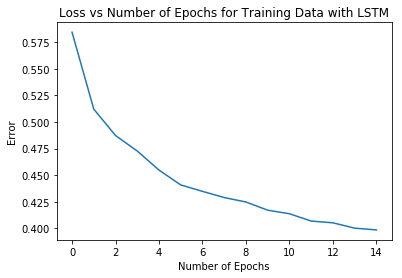

The test set had a loss of: 0.43854166666666666


In [14]:
plt.plot(lstm_error)
plt.ylabel("Error")
plt.xlabel("Number of Epochs")
plt.title("Loss vs Number of Epochs for Training Data with LSTM")
plt.show()
print("The test set had a loss of:", test_lstm_error)

In [15]:
Synthesize(MyBasicLSTMCell, "I seek to slay thee with my sword. Come and accept your defeat.")
Synthesize(MyBasicLSTMCell, "I want to climb up the Eiffel Tower someday.")
Synthesize(MyBasicLSTMCell, "I really like pie. Especially chocolate pie")
Synthesize(MyBasicLSTMCell, "I hate doing anything. I just want to sit in my room all day.")

there are preprocessed data - lets load it
[21  0  6  1  1 28  0  2  3  0  6 11  4 15  0  2  5  1  1  0 17  9  2  5
  0 14 15  0  6 17  3  7 12 25  0 37  3 14  1  0  4  8 12  0  4 19 19  1
 23  2  0 15  3 13  7  0 12  1 18  1  4  2 25]
INFO:tensorflow:Restoring parameters from saved_model
data length 63
I seek to slay thee with my sword. Come and accept your defeat.
I he be not a champirate is no brother's blood
For thine own dear blood of mine eye
I man this isly
there are preprocessed data - lets load it
[21  0 17  4  8  2  0  2  3  0 19 11  9 14 22  0 13 23  0  2  5  1  0 31
  9 18 18  1 11  0 29  3 17  1  7  0  6  3 14  1 12  4 15 25]
INFO:tensorflow:Restoring parameters from saved_model
data length 44
I want to climb up the Eiffel Tower someday.

QUEEN ANLIE:
A countinious bear, a time. I'll not look'd.
What!

PRINCE EDWARD:
Anough till this s
there are preprocessed data - lets load it
[21  0  7  1  4 11 11 15  0 11  9 28  1  0 23  9  1 25  0 31  6 23  1 19
  9  4 11 11 15  0 19  

### (b) Run the same experiment with the basic RNN architecture. This has 1/4 of the parameters of the LSTM. Compare the training error plot with the original LSTM. Compare the test set error.

In [16]:
args.num_epochs = 15
rnn_loss, rnn_error = trainer(MyBasicRNNCell)
test_rnn_loss, test_rnn_error = Tester(MyBasicRNNCell)

train_num_batches 185
epoch: 0 loss: 2.2731872900112253 error: 0.5654166666666667
epoch: 1 loss: 1.832771823212907 error: 0.5195833333333333
epoch: 2 loss: 1.689747801342526 error: 0.49416666666666664
epoch: 3 loss: 1.6092528407638138 error: 0.47375
epoch: 4 loss: 1.5579535832276215 error: 0.460625
epoch: 5 loss: 1.5212441031997268 error: 0.456875
epoch: 6 loss: 1.4939064863565805 error: 0.44958333333333333
epoch: 7 loss: 1.472657544548447 error: 0.4427083333333333
epoch: 8 loss: 1.4556025337528538 error: 0.4375
epoch: 9 loss: 1.4413978634653866 error: 0.4347916666666667
epoch: 10 loss: 1.4293489108214508 error: 0.43
epoch: 11 loss: 1.4191420741983363 error: 0.42645833333333333
epoch: 12 loss: 1.4103755409653123 error: 0.42604166666666665
epoch: 13 loss: 1.402745888684247 error: 0.42520833333333335
epoch: 14 loss: 1.3961015707737692 error: 0.425
00 hours 00 minutes 57.06 seconds
there are preprocessed data - lets load it
[39  5  1  7  1  0  4  7  1  0 15  3 13  0 20  3  9  8 20  0  2  

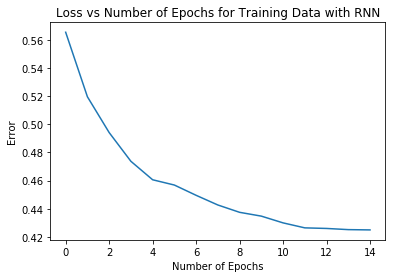

The test set had a loss of: 0.458125


In [17]:
plt.plot(rnn_error)
plt.ylabel("Error")
plt.xlabel("Number of Epochs")
plt.title("Loss vs Number of Epochs for Training Data with RNN")
plt.show()
print("The test set had a loss of:", test_rnn_error)

In [18]:
Synthesize(MyBasicRNNCell, "I seek to slay thee with my sword. Come and accept your defeat.")
Synthesize(MyBasicRNNCell, "I want to climb up the Eiffel Tower someday.")
Synthesize(MyBasicRNNCell, "I really like pie. Especially chocolate pie")
Synthesize(MyBasicRNNCell, "I hate doing anything. I just want to sit in my room all day.")

there are preprocessed data - lets load it
[21  0  6  1  1 28  0  2  3  0  6 11  4 15  0  2  5  1  1  0 17  9  2  5
  0 14 15  0  6 17  3  7 12 25  0 37  3 14  1  0  4  8 12  0  4 19 19  1
 23  2  0 15  3 13  7  0 12  1 18  1  4  2 25]
INFO:tensorflow:Restoring parameters from saved_model
data length 63
I seek to slay thee with my sword. Come and accept your defeat.

BUCKINGHAM:
She so.

PETRUCHIO:
Where'er what hath twife and my father's death tent at our gates o
there are preprocessed data - lets load it
[21  0 17  4  8  2  0  2  3  0 19 11  9 14 22  0 13 23  0  2  5  1  0 31
  9 18 18  1 11  0 29  3 17  1  7  0  6  3 14  1 12  4 15 25]
INFO:tensorflow:Restoring parameters from saved_model
data length 44
I want to climb up the Eiffel Tower someday.

LUCIO:
I see there would here been a batter my found of the king.

ARCETIO:
Well, this is night ou
there are preprocessed data - lets load it
[21  0  7  1  4 11 11 15  0 11  9 28  1  0 23  9  1 25  0 31  6 23  1 19
  9  4 11 11 15  0 19  

The RNN had about a 3% higher error rate. This is quite significant and thus the LSTM definitely performed better. However, this behavior is expected, so I am not suprised. The LSTM also took significantly longer to run, but this is expected and a better error rate almost always coincides with the lower error rate.

I think the most interesting part is the plateau in the RNN error rate. This clearly demonstrates that there are severe limitations to the RNN. This is expected as looking at the history of past words is extremely important in such a situation and thus it makes sense that the RNN will plateau when the LSTM will not.

I found the responses for the synthesize amuzing, but given that the data set was shakespeare, it was never going to properly give responses to most sentences.

### (c) Try 5 alternatives. For example an RNN with the same number of parameters as the LSTM. Or an RNN with more than one internal layer. Explain each of your models, plot the training error rate functions as a function of epoch for all your models and show the error rates on the test set as well.

### (d) For each model, run a simulation starting with the same initialization text of your choice.

### Note: I do both (c) and (d) at the same time.

In [19]:
def synthesizePhrases(cell):
    Synthesize(cell, "I seek to slay thee with my sword. Come and accept your defeat.")
    Synthesize(cell, "I want to climb up the Eiffel Tower someday.")
    Synthesize(cell, "I really like pie. Especially chocolate pie")
    Synthesize(cell, "I hate doing anything. I just want to sit in my room all day.")


def trainRNNwithLSTMParemters():
    print("\n")
    print("RUNNING MODEL 1: RNN with the same parameters as LSTM")
    args.num_units = 128*8
    model_loss = trainer(MyBasicRNNCell)
    model_test_loss = Tester(MyBasicRNNCell)
    print("Starting Synthesize:")
    print("------------------------------------------")
    synthesizePhrases(MyBasicRNNCell)
    print("------------------------------------------")
    args.num_units = 128*2
    print("\n")
    return model_loss[1], model_test_loss[1]

def trainLSTMwithRNNParemters():
    print("\n")
    print("RUNNING MODEL 2: LSTM with the double parameters as usual")
    args.num_units = 64
    model_loss = trainer(MyBasicLSTMCell)
    model_test_loss = Tester(MyBasicLSTMCell)
    print("Starting Synthesize:")
    print("------------------------------------------")
    synthesizePhrases(MyBasicLSTMCell)
    print("------------------------------------------")
    args.num_units = 128*2
    print("\n")
    return model_loss[1], model_test_loss[1]

def trainRNNwithHalfParemters():
    print("\n")
    print("RUNNING MODEL 3: RNN with half the parameters")
    args.num_units = 64
    model_loss = trainer(MyBasicRNNCell)
    model_test_loss = Tester(MyBasicRNNCell)
    print("Starting Synthesize:")
    print("------------------------------------------")
    synthesizePhrases(MyBasicRNNCell)
    print("------------------------------------------")
    args.num_units = 128*2
    print("\n")
    return model_loss[1], model_test_loss[1]


class MyMultiRNNCell(tf.contrib.rnn.BasicRNNCell):
    def build(self, inputs_shape):

        input_depth = inputs_shape[1].value
        
        self.W1 = self.add_variable(name="W1", shape=[input_depth + self._num_units, self._num_units])
        self.b1 = self.add_variable(name="b1", shape=[self._num_units], initializer=tf.zeros_initializer())
        self.W2 = self.add_variable(name="W2", shape=[input_depth + self._num_units, self._num_units])
        self.b2 = self.add_variable(name="b2", shape=[self._num_units], initializer=tf.zeros_initializer())
        
        self.built = True

    def call(self, inputs, state):
        """Most basic RNN: output = new_state = act(W * input + U * state + B)."""
        
        output1 = tf.tanh(tf.matmul(tf.concat([inputs, state], 1), self.W1)) + self.b1
        output = tf.tanh(tf.matmul(tf.concat([inputs, state], 1), self.W2)) + self.b2

        return output, output
    
def trainRNNwith2Layers():
    print("\n")
    print("RUNNING MODEL 4: RNN with 2 Layers")
    model_loss = trainer(MyMultiRNNCell)
    model_test_loss = Tester(MyMultiRNNCell)
    print("Starting Synthesize:")
    print("------------------------------------------")
    synthesizePhrases(MyMultiRNNCell)
    print("------------------------------------------")
    print("\n")
    return model_loss[1], model_test_loss[1]

def train2LayerRNNwithLSTMParams():
    print("\n")
    print("RUNNING MODEL 5: RNN with 2 Layers and the same Parameters as LSTM")
    args.num_units = 128*8
    model_loss = trainer(MyMultiRNNCell)
    model_test_loss = Tester(MyMultiRNNCell)
    print("Starting Synthesize:")
    print("------------------------------------------")
    synthesizePhrases(MyMultiRNNCell)
    print("------------------------------------------")
    args.num_units = 128*2
    print("\n")
    return model_loss[1], model_test_loss[1]

My first alternative is running RNN with the LSTM parameters. I am curious to see how RNN will run relative to LSTM with the same parameters. 

My second alternative is running LSTM with RNN parameters. I am also curious to see how LSTM will run when scaled down to RNN. 

My third alternative is running RNN will half its parameters. I picked this one cause I want to compare running LSTM will less params with RNN with less parameters. 

My forth alternative is running RNN with 2 layers. I want to compare the adding of adding a layer with the effect of adding parameters. 

My final and fifth alternative is running RNN with 2 layers and the same paramters as LSTM. I want to see if RNN can perform better than LSTM and by making it better in both ways, I am curious to see it turns out to be better.

---------------
The testing raw data, training run data and synthesize data will be found as the result of the following cell. Below, I will the errors to compare them between models.

In [20]:
args.num_epochs = 15
model_train_errors = [lstm_error[:args.num_epochs], rnn_error[:args.num_epochs]]
model_test_errors = [test_lstm_error, test_rnn_error]
mls = trainRNNwithLSTMParemters()
model_train_errors.append(mls[0])
model_test_errors.append(mls[1])

mls = trainLSTMwithRNNParemters()
model_train_errors.append(mls[0])
model_test_errors.append(mls[1])

mls = trainRNNwithHalfParemters()
model_train_errors.append(mls[0])
model_test_errors.append(mls[1])

mls = trainRNNwith2Layers()
model_train_errors.append(mls[0])
model_test_errors.append(mls[1])

mls = train2LayerRNNwithLSTMParams()
model_train_errors.append(mls[0])
model_test_errors.append(mls[1])




RUNNING MODEL 1: RNN with the same parameters as LSTM
train_num_batches 185
epoch: 0 loss: 2.4205893033259622 error: 0.575
epoch: 1 loss: 1.9105165533117345 error: 0.5216666666666666
epoch: 2 loss: 1.7005282878875732 error: 0.49916666666666665
epoch: 3 loss: 1.6059870739240905 error: 0.4764583333333333
epoch: 4 loss: 1.544860122654889 error: 0.458125
epoch: 5 loss: 1.5023100202148025 error: 0.4475
epoch: 6 loss: 1.4735500026393582 error: 0.4397916666666667
epoch: 7 loss: 1.4494780540466308 error: 0.433125
epoch: 8 loss: 1.4340053996524296 error: 0.4345833333333333
epoch: 9 loss: 1.4157990984014563 error: 0.42583333333333334
epoch: 10 loss: 1.422347898741026 error: 0.43020833333333336
epoch: 11 loss: 1.4340947570027531 error: 0.4266666666666667
epoch: 12 loss: 1.4130288691134065 error: 0.43104166666666666
epoch: 13 loss: 1.4008325396357355 error: 0.42541666666666667
epoch: 14 loss: 1.3904046670810597 error: 0.4241666666666667
00 hours 03 minutes 27.36 seconds
there are preprocessed da

[21  0  7  1  4 11 11 15  0 11  9 28  1  0 23  9  1 25  0 31  6 23  1 19
  9  4 11 11 15  0 19  5  3 19  3 11  4  2  1  0 23  9  1]
INFO:tensorflow:Restoring parameters from saved_model
data length 43
I really like pie. Especially chocolate pies to ming alound the mode the tently hure bore, be server the but hene, brother hing and the concain
there are preprocessed data - lets load it
[21  0  5  4  2  1  0 12  3  9  8 20  0  4  8 15  2  5  9  8 20 25  0 21
  0 54 13  6  2  0 17  4  8  2  0  2  3  0  6  9  2  0  9  8  0 14 15  0
  7  3  3 14  0  4 11 11  0 12  4 15 25]
INFO:tensorflow:Restoring parameters from saved_model
data length 61
I hate doing anything. I just want to sit in my room all day.
In than the sould to him the chisend the boud, than to still though the to the seess the brownot to
------------------------------------------




RUNNING MODEL 4: RNN with 2 Layers
train_num_batches 185
epoch: 0 loss: 2.2777854513477633 error: 0.5702083333333333
epoch: 1 loss: 1.8355257311382

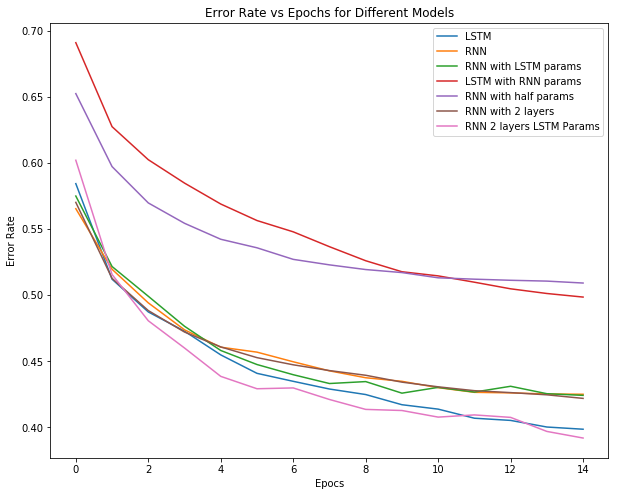

In [21]:
plt.figure(figsize=(10,8))
for er in model_train_errors:
    plt.plot(er)
plt.legend(['LSTM', 'RNN', 'RNN with LSTM params', 'LSTM with RNN params', 'RNN with half params', 'RNN with 2 layers', 'RNN 2 layers LSTM Params'])
plt.xlabel("Epocs")
plt.ylabel("Error Rate")
plt.title("Error Rate vs Epochs for Different Models")
plt.show()

Text(0.5,1,'Test error rate per model')

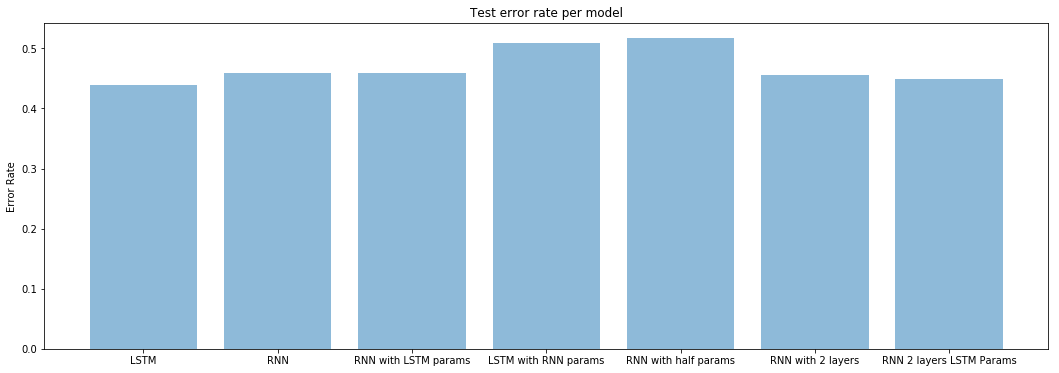

In [22]:
plt.figure(figsize=(18,6))
objects = ('LSTM', 'RNN', 'RNN with LSTM params', 'LSTM with RNN params', 'RNN with half params', 'RNN with 2 layers', 'RNN 2 layers LSTM Params')
y_pos = np.arange(len(objects))
performance = model_test_errors

plt.bar(y_pos, performance, align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.ylabel('Error Rate')
plt.title('Test error rate per model')

The LSTM and RNN with 2 layers and LSTM params (model 5) performed about the same. At lower epochs, the RNN with 2 layers and LSTM params performed better but the LSTM caught up later. I was excited to see that model 5 was able to perform as well as the LSTM while only using RNN. It does make sense that the LSTM did eventually catch up as it allowed time for the long term memory to come into effect. However, model 5 did have a runtime that was about a minute longer. This makes sense as using more layers and parameters definitely slows the runtime down significantly, but I still found these results interesting. THe next best was RNN with 2 layers, which slightly outperformed RNN and RNN with LSTM parameters. RNN performed slightly worse than the other 2, but his is expected as adding another layer or additional parameters should make RNN more accurate. On the training data, they all performed about the same. Finally the LSTM with RNN parameters slightly beat out the RNN with half parameters, which were both far behind the rest. This shows that with both RNN and LSTM the default paramters are the paramters, which minimize the error rate in a timely efficient manner. All models with additional paramters and layers performed slow for the increase they provided and the models with lower parameters ones increase the error rate significantly.

Overall, I found these results interesting and I was glad to see that I was able to make an RNN that performed as well as the LSTM even if it took significantly longer. Adding a layer had a more significant effect than adding inputs and decreasing the inputs had a significant dropoff.  

Similar to above, the synthesize results were funny, but not too telling of anything conclusive.